In [1]:
#Install Required Libraries
!pip install tensorflow matplotlib opencv-python
!pip install segmentation-models==1.0.1

In [2]:
#Import Libraries
import os, glob
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0
import matplotlib.pyplot as plt
import segmentation_models as sm

#Set framework for segmentation_models
sm.set_framework('tf.keras')


Segmentation Models: using `keras` framework.


In [3]:
#Configuration
BACKBONE = 'efficientnetb0'
IMAGE_SIZE = (256, 256)
BATCH_SIZE = 8
NUM_CLASSES = 1  # Binary segmentation

In [4]:
# Dataset paths
TRAIN_IMG_DIR = "DATASET/dataset/train/images"
TRAIN_MASK_DIR = "DATASET/dataset/train/masks"
VAL_IMG_DIR = "DATASET/dataset/validation/images"
VAL_MASK_DIR = "DATASET/dataset/validation/masks"
TEST_IMG_DIR = "DATASET/dataset/test/images"
TEST_MASK_DIR = "DATASET/dataset/test/masks"

In [5]:
#Print dataset stats
print("Train images:", len(glob.glob(os.path.join(TRAIN_IMG_DIR, "*.png"))))
print("Train masks :", len(glob.glob(os.path.join(TRAIN_MASK_DIR, "*.png"))))
print("Val images  :", len(glob.glob(os.path.join(VAL_IMG_DIR, "*.png"))))
print("Val masks   :", len(glob.glob(os.path.join(VAL_MASK_DIR, "*.png"))))
print("Test images :", len(glob.glob(os.path.join(TEST_IMG_DIR, "*.png"))))
print("Test masks  :", len(glob.glob(os.path.join(TEST_MASK_DIR, "*.png"))))

Train images: 1385
Train masks : 1385
Val images  : 396
Val masks   : 396
Test images : 199
Test masks  : 199


In [6]:
def load_image_mask(image_path, mask_path, image_size=IMAGE_SIZE):
    # Load grayscale image
    image = cv2.imread(image_path.decode(), cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, image_size)
    image = np.stack((image,)*3, axis=-1)
    image = image.astype(np.float32) / 255.0

    # Load mask
    mask = cv2.imread(mask_path.decode(), cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, image_size, interpolation=cv2.INTER_NEAREST)
    mask = (mask > 127).astype(np.float32)
    mask = np.expand_dims(mask, axis=-1)
    
    return image, mask

def tf_load_wrapper(image_path, mask_path):
    image, mask = tf.numpy_function(
        load_image_mask, [image_path, mask_path], [tf.float32, tf.float32]
    )
    image.set_shape((*IMAGE_SIZE, 3))
    mask.set_shape((*IMAGE_SIZE, 1))
    return image, mask

In [7]:
#Dataset creation function with optional augmentation
def create_dataset(images_dir, masks_dir, batch_size=BATCH_SIZE, repeat=False):
    image_files = sorted(glob.glob(os.path.join(images_dir, "*.png")))
    mask_files = sorted(glob.glob(os.path.join(masks_dir, "*.png")))

    dataset = tf.data.Dataset.from_tensor_slices((image_files, mask_files))
    dataset = dataset.map(tf_load_wrapper, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size)

    if repeat:
        dataset = dataset.repeat()

    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

Images shape: (8, 256, 256, 3)
Masks shape : (8, 256, 256, 1)
Images min/max: 0.07058824 0.7647059
Masks unique values: [0. 1.]


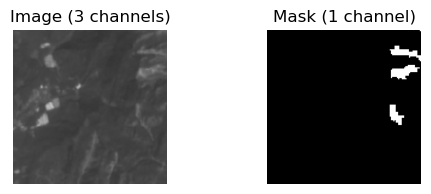

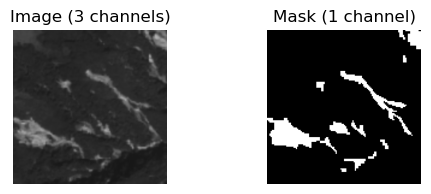

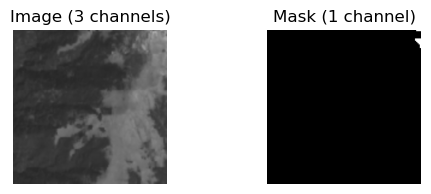

Image dtype: <dtype: 'float32'>
Mask dtype: <dtype: 'float32'>


In [8]:
#Create datasets
train_ds = create_dataset(TRAIN_IMG_DIR, TRAIN_MASK_DIR, repeat=True)
val_ds = create_dataset(VAL_IMG_DIR, VAL_MASK_DIR)
test_ds = create_dataset(TEST_IMG_DIR, TEST_MASK_DIR)

# Check batch shapes
for images, masks in train_ds.take(1):
    print("Images shape:", images.shape)
    print("Masks shape :", masks.shape)
    print("Images min/max:", tf.reduce_min(images).numpy(), tf.reduce_max(images).numpy())
    print("Masks unique values:", np.unique(masks.numpy()))

    # Visualize samples
    for i in range(min(3, images.shape[0])):
        plt.figure(figsize=(6,2))
        plt.subplot(1,2,1)
        plt.imshow(images[i].numpy())
        plt.title("Image (3 channels)")
        plt.axis('off')
        plt.subplot(1,2,2)
        plt.imshow(masks[i,:,:,0].numpy(), cmap='gray')
        plt.title("Mask (1 channel)")
        plt.axis('off')
        plt.show()

print("Image dtype:", images.dtype)
print("Mask dtype:", masks.dtype)

In [9]:
def build_unet(input_shape=(256,256,3)):
    base_model = EfficientNetB0(include_top=False, weights=None, input_shape=input_shape)

    skips = [
        base_model.get_layer("block2a_expand_activation").output,   # 128x128
        base_model.get_layer("block3a_expand_activation").output,   # 64x64
        base_model.get_layer("block4a_expand_activation").output,   # 32x32
        base_model.get_layer("block6a_expand_activation").output,   # 16x16
    ]
    encoder_output = base_model.get_layer("top_activation").output  # 8x8

    x = encoder_output
    for skip in reversed(skips):
        x = layers.Conv2DTranspose(256, 3, strides=2, padding="same")(x)
        x = layers.Concatenate()([x, skip])
        x = layers.Conv2D(256, 3, activation="relu", padding="same")(x)
        x = layers.Conv2D(256, 3, activation="relu", padding="same")(x)

    x = layers.Conv2DTranspose(128, 3, strides=2, padding="same")(x)
    x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
    outputs = layers.Conv2D(1, 1, activation="sigmoid")(x)

    return models.Model(base_model.input, outputs)

In [10]:
#Binary Focal Loss
from tensorflow.keras import backend as K

def binary_focal_loss(gamma=2., alpha=0.25):
    def focal_loss(y_true, y_pred):
        y_true = K.flatten(y_true)
        y_pred = K.flatten(y_pred)
        bce = K.binary_crossentropy(y_true, y_pred)
        bce_exp = K.exp(-bce)
        focal_loss = alpha * K.pow((1 - bce_exp), gamma) * bce
        return K.mean(focal_loss)
    return focal_loss


In [11]:
#Compile Model
model = build_unet()
model.compile(optimizer="adam", loss=binary_focal_loss(gamma=2., alpha=0.25), metrics=["accuracy"])

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss')
]

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 256, 256,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 256, 256,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 257, 257,  │          0 │ normalization[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 128, 128,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 128, 128,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 128, 128,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 128, 128,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 128, 128,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 128, 128,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 128, 128,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 128, 128,  │        512 │ block1a_se_excit… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 128, 128,  │         64 │ block1a_project_

 Total params: 16,512,932 (62.99 MB)

 Trainable params: 16,470,909 (62.83 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [12]:
steps_per_epoch = len(glob.glob(os.path.join(TRAIN_IMG_DIR, "*.png"))) // BATCH_SIZE
validation_steps = len(glob.glob(os.path.join(VAL_IMG_DIR, "*.png"))) // BATCH_SIZE
EPOCHS = 5

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=callbacks
)

Epoch 1/5
173/173 ━━━━━━━━━━━━━━━━━━━━ 6422s 37s/step - accuracy: 0.9524 - loss: 0.0090 - val_accuracy: 0.9598 - val_loss: 0.0353
Epoch 2/5
173/173 ━━━━━━━━━━━━━━━━━━━━ 4502s 26s/step - accuracy: 0.9576 - loss: 0.0078 - val_accuracy: 0.9598 - val_loss: 0.0525
Epoch 3/5
173/173 ━━━━━━━━━━━━━━━━━━━━ 5343s 31s/step - accuracy: 0.9585 - loss: 0.0068 - val_accuracy: 0.9598 - val_loss: 0.0376
Epoch 4/5
173/173 ━━━━━━━━━━━━━━━━━━━━ 4830s 28s/step - accuracy: 0.9602 - loss: 0.0064 - val_accuracy: 0.9599 - val_loss: 0.0128
Epoch 5/5
173/173 ━━━━━━━━━━━━━━━━━━━━ 4408s 25s/step - accuracy: 0.9605 - loss: 0.0063 - val_accuracy: 0.9671 - val_loss: 0.0055


In [13]:
# Evaluate Model
print("\n📊 Test Evaluation:")
model.evaluate(test_ds)
model.save("landslide_segmentation_unet_effnetb0_fixedImbalance.keras")


📊 Test Evaluation:
25/25 ━━━━━━━━━━━━━━━━━━━━ 111s 4s/step - accuracy: 0.9615 - loss: 0.0063


1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


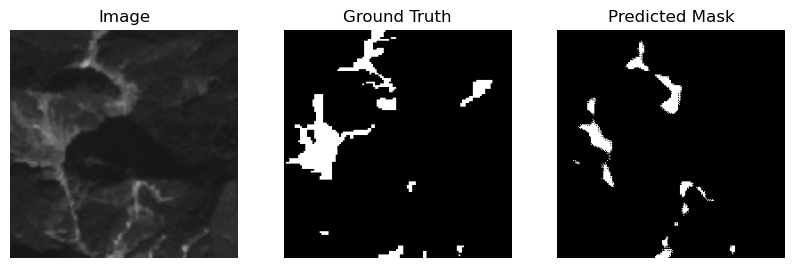

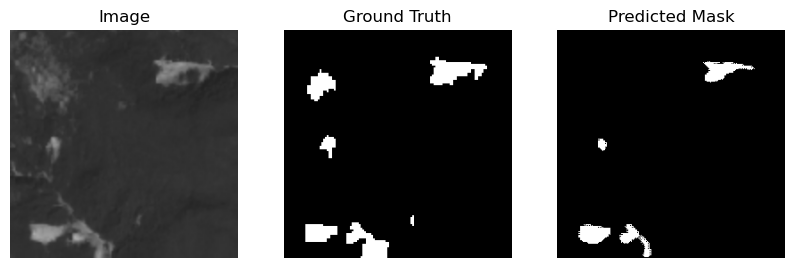

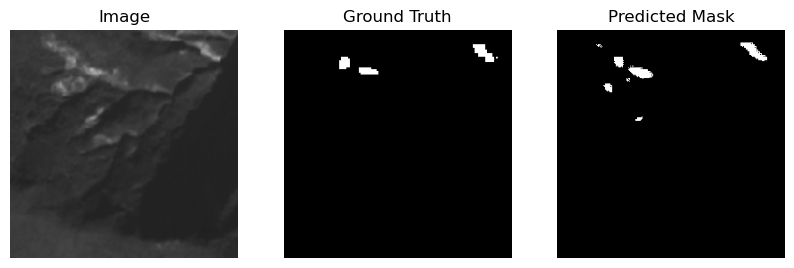

In [14]:
#Visualization of Predictions
for images, masks in val_ds.take(1):
    preds = model.predict(images)
    preds = (preds > 0.5).astype(np.uint8)

    for i in range(min(3, images.shape[0])):
        plt.figure(figsize=(10,3))
        plt.subplot(1,3,1)
        plt.imshow(images[i].numpy())
        plt.title("Image")
        plt.axis('off')

        plt.subplot(1,3,2)
        plt.imshow(masks[i,:,:,0].numpy(), cmap='gray')
        plt.title("Ground Truth")
        plt.axis('off')

        plt.subplot(1,3,3)
        plt.imshow(preds[i,:,:,0], cmap='gray')
        plt.title("Predicted Mask")
        plt.axis('off')

        plt.show()

25/25 ━━━━━━━━━━━━━━━━━━━━ 119s 5s/step
Accuracy : 0.9615
Precision: 0.6368
Recall   : 0.3889
F1 Score : 0.4829
ROC AUC  : 0.9597
Confusion Matrix:
 [[12304536   133844]
 [  368640   234644]]


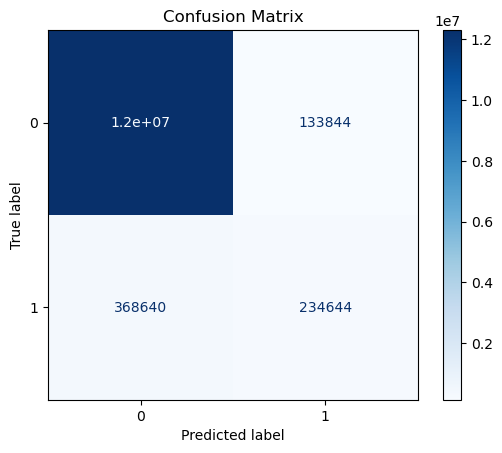

In [15]:
#Performance Metrics
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

# Step 1: Get predictions
# Predict probabilities on test dataset
y_prob = model.predict(test_ds)  # For binary classification, shape: (num_samples, 1)
y_prob = y_prob.flatten()        # Flatten to 1D array

# Convert probabilities to class predictions (threshold=0.5)
y_pred = (y_prob >= 0.5).astype(int)

# Step 2: Get true labels
# Extract labels from test dataset
y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_true = y_true.flatten()  # Flatten to 1D array

# Step 3: Compute metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
roc_auc = roc_auc_score(y_true, y_prob)
cm = confusion_matrix(y_true, y_pred)

# Print results
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")
print(f"ROC AUC  : {roc_auc:.4f}")
print("Confusion Matrix:\n", cm)

# Step 4: Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()
